In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
%pwd

'/content/drive/My Drive/Colab Notebooks'

In [ ]:
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.9MB 35.5MB/s 
     |████████████████████████████████| 450kB 59.0MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [ ]:
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 15.7MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
import keras
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D, Lambda, Dense, Reshape, Flatten, concatenate, Add
from keras import regularizers

 
def compact_bilinear(tensors_list):

    def _generate_sketch_matrix(rand_h, rand_s, output_dim):
        # Generate a sparse matrix for tensor count sketch
        rand_h = rand_h.astype(np.int64)
        rand_s = rand_s.astype(np.float32)
        assert (rand_h.ndim == 1 and rand_s.ndim == 1 and len(rand_h) == len(rand_s))
        assert (np.all(rand_h >= 0) and np.all(rand_h < output_dim))

        input_dim = len(rand_h)
        indices = np.concatenate((np.arange(input_dim)[..., np.newaxis],
                                  rand_h[..., np.newaxis]), axis=1)
        sparse_sketch_matrix = tf.sparse.reorder(tf.sparse.SparseTensor(indices, rand_s, [input_dim, output_dim]))
        return sparse_sketch_matrix

    bottom1, bottom2 = tensors_list
    output_dim = 8192

    # Static shapes are needed to construction count sketch matrix
    input_dim1 = bottom1.get_shape().as_list()[-1]
    input_dim2 = bottom2.get_shape().as_list()[-1]

    #Generate vectors and sketch matrix for tensor count sketch
    seed_h_1 = 1
    seed_s_1 = 3
    seed_h_2 = 5
    seed_s_2 = 7

    # Generate sparse_sketch_matrix1 using rand_h_1 and rand_s_1
    np.random.seed(seed_h_1)
    rand_h_1 = np.random.randint(output_dim, size=input_dim1)
    np.random.seed(seed_s_1)
    rand_s_1 = 2 * np.random.randint(2, size=input_dim1) - 1
    sparse_sketch_matrix1 = _generate_sketch_matrix(rand_h_1, rand_s_1, output_dim)

    # Generate sparse_sketch_matrix2 using rand_h_2 and rand_s_2
    np.random.seed(seed_h_2)
    rand_h_2 = np.random.randint(output_dim, size=input_dim2)
    np.random.seed(seed_s_2)
    rand_s_2 = 2 * np.random.randint(2, size=input_dim2) - 1
    sparse_sketch_matrix2 = _generate_sketch_matrix(rand_h_2, rand_s_2, output_dim)

    # Flatten the input tensors and count sketch
    bottom1_flat = tf.reshape(bottom1, [-1, input_dim1])
    bottom2_flat = tf.reshape(bottom2, [-1, input_dim2])

    sketch1 = tf.transpose(tf.sparse.sparse_dense_matmul(sparse_sketch_matrix1,
                                                         bottom1_flat, adjoint_a=True, adjoint_b=True))
    sketch2 = tf.transpose(tf.sparse.sparse_dense_matmul(sparse_sketch_matrix2,
                                                         bottom2_flat, adjoint_a=True, adjoint_b=True))

    #FFT
    fft1 = tf.signal.fft(tf.complex(real=sketch1, imag=tf.zeros_like(sketch1)))
    fft2 = tf.signal.fft(tf.complex(real=sketch2, imag=tf.zeros_like(sketch2)))

    #Elementwise product
    fft_product = tf.multiply(fft1, fft2)

    #Inverse FFT and reshape back
    cbp_flat = tf.math.real(tf.signal.ifft(fft_product))

    output_shape = tf.add(tf.multiply(tf.shape(bottom1), [1, 1, 1, 0]),
                          [0, 0, 0, output_dim])
    cbp = tf.reshape(cbp_flat, output_shape)

    return cbp


def vgg_16_cbcnn(input_shape, no_classes, bilinear_output_dim, sum_pool=True, weight_decay_constant=5e-4,
                 multi_label=False, weights_path=None):

    weights_regularizer = regularizers.l2(weight_decay_constant)

    # Input layer
    img_input = Input(shape=input_shape, name='spectr_input')
    print(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1',
               kernel_regularizer=weights_regularizer)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2',
               kernel_regularizer=weights_regularizer)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1',
               kernel_regularizer=weights_regularizer)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2',
               kernel_regularizer=weights_regularizer)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1',
               kernel_regularizer=weights_regularizer)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2',
               kernel_regularizer=weights_regularizer)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3',
               kernel_regularizer=weights_regularizer)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1',
               kernel_regularizer=weights_regularizer)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2',
               kernel_regularizer=weights_regularizer)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3',
               kernel_regularizer=weights_regularizer)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1',
               kernel_regularizer=weights_regularizer)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2',
               kernel_regularizer=weights_regularizer)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3',
               kernel_regularizer=weights_regularizer)(x)

    # Merge using compact bilinear method
    compact_bilinear_arg_list = [x, x]

    output_shape_x = x.get_shape().as_list()[1:]
    output_shape_cb = (output_shape_x[0], output_shape_x[1], bilinear_output_dim,)
    x=Lambda(compact_bilinear, output_shape=output_shape_cb)(compact_bilinear_arg_list)
    if sum_pool:
        x = Lambda(lambda x: K.sum(x, axis=[1, 2]))(x)

    # Sign sqrt and L2 normalize result
    x = Lambda(lambda x: K.sign(x) * K.sqrt(K.abs(x)))(x)
    x = Lambda(lambda x: K.l2_normalize(x, axis=-1))(x)

    final_activation = 'sigmoid'
    x = Dense(1, activation='sigmoid', name='sigmoid_layer', kernel_regularizer=weights_regularizer)(x)

    model = Model(inputs=[img_input], outputs=[x])
    if weights_path:
        model.load_weights(weights_path, by_name=True)
    return model

In [ ]:
import os
import sys

import functools
import numpy as np
import pandas as pd

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import top_k_categorical_accuracy
from keras.optimizers import Adam

#from data_helpers import load_dataset
#import vgg_cbcnn as vgb
import tensorflow as tf
#tf.disable_v2_behavior() 

batch_size = 64
input_shape = (150, 150, 3,)

bilinear_output_dim = 8192
no_classes = 2
INITIAL_LR = 1.0
train_count = 3216
val_count = 1072
vgg_weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
DNN_BEST_MODEL = 'ft_last_layer.hdf5'
EPOCHS_PATIENCE_BEFORE_STOPPING = 5
EPOCHS_PATIENCE_BEFORE_DECAY = 2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255) 
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
'/content/drive/My Drive/final_year_project/IMAC/training/', 
target_size=(150,150), 
batch_size=64, 
class_mode='binary'
)

val_generator = validation_datagen.flow_from_directory(
'/content/drive/My Drive/final_year_project/IMAC/validation/', 
target_size=(150, 150),
batch_size=64,
class_mode='binary'
)

train_batches = int(np.ceil(train_count / batch_size))
val_batches = int(np.ceil(val_count / batch_size))

cbcnn_model = vgg_16_cbcnn(input_shape=(150, 150, 3), no_classes=no_classes,
                               bilinear_output_dim=8192, sum_pool=True, weight_decay_constant=5e-6,
                               multi_label=False, weights_path=vgg_weights_path)
print (cbcnn_model.summary())

for layer in cbcnn_model.layers[:-1]:
    layer.trainable = False
print (cbcnn_model.summary())

adm=Adam()
#cbcnn_model.load_weights(DNN_BEST_MODEL)
cbcnn_model.compile(loss='binary_crossentropy',optimizer=adm,metrics=['acc'])

check_pointer = ModelCheckpoint(monitor='val_loss', filepath=DNN_BEST_MODEL, verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=EPOCHS_PATIENCE_BEFORE_STOPPING)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=EPOCHS_PATIENCE_BEFORE_DECAY,
                                             verbose=1, min_lr=1e-7)

history=cbcnn_model.fit_generator(generator=train_generator, steps_per_epoch=train_batches,
                              epochs=50, verbose=1, validation_data=val_generator,
                              validation_steps=val_batches,
                              callbacks=[check_pointer, reduce_lr_on_plateau, early_stopper])


Found 3213 images belonging to 2 classes.
Found 1072 images belonging to 2 classes.
(150, 150, 3)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spectr_input (InputLayer)       (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 150, 150, 64) 1792        spectr_input[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 150, 150, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 75, 75, 64)   0           block1_conv2[0][0]          

In [ ]:
cbcnn_model.save("/content/drive/My Drive/final_year_project/IMAC_saved_model_using_vgg_layers-bilinear_pooling-new")

In [ ]:
import tensorflow as tf
import keras
model = keras.models.load_model('/content/drive/My Drive/final_year_project/IMAC_saved_model_using_vgg_layers-bilinear_pooling-new', custom_objects={'tf': tf})

Text(0.5, 1.0, 'Accuracy Curves')

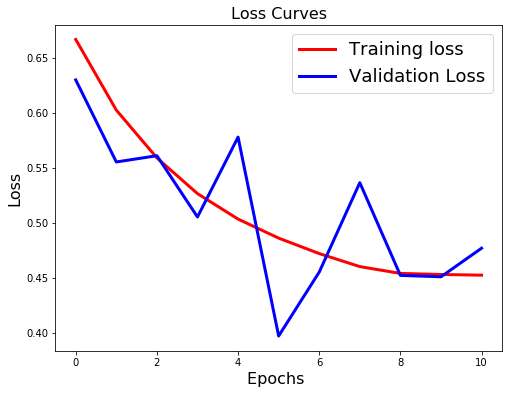

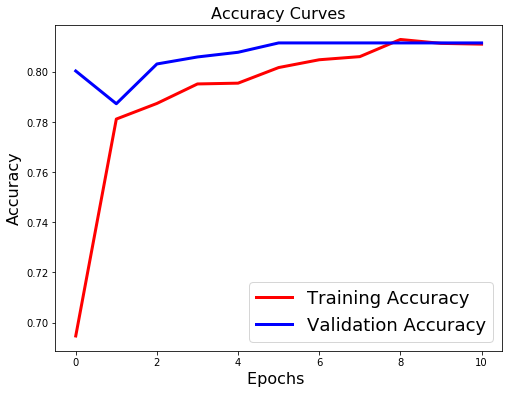

In [ ]:
#Plot the Loss Curves
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/final_year_project/IMAC/testing',
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary', 
        shuffle=False)

Found 1072 images belonging to 2 classes.


In [ ]:
pred = model.predict_generator(test_generator, verbose=1)

1072/1072 [==============================] - 583s 544ms/step


In [ ]:
results= model.evaluate(test_generator, verbose=1)

1072/1072 [==============================] - 13s 12ms/step


In [ ]:
import numpy as np

In [ ]:
y_pred = np.empty([1072])
for i in range(1072): 
  if pred[i]>0.5:
    #print(i)
    y_pred[i]=1
    #print(" is sad")
  else:
    #print(i)
    y_pred[i]=0
    #print(" is happy")

In [ ]:
print("Evaluation for model trained using 4 Conv layers")
from sklearn.metrics import confusion_matrix       #Confusion For inception
cm=confusion_matrix(test_generator.classes,y_pred)
print("Confusion Matrix: ")
print(cm)

print('Test loss, Test accuracy:', results)
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_generator.classes,y_pred)

print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1score: {}'.format(fscore))
print('Support: {}'.format(support))

#For specificity
spec=[0,0]
spec[0]=cm[1,1]/(cm[0,1]+cm[1,1])
spec[1]=cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: {}'.format(spec))

#print("Classification Report: ")
#from sklearn.metrics import classification_report as report
#rep=report(test_generator.classes,y_pred)
#print(rep)

Evaluation for model trained using 4 Conv layers
Confusion Matrix: 
[[455  90]
 [ 92 435]]
Test loss, Test accuracy: [0.38926956057548523, 0.8302238583564758]
Precision: [0.83180987 0.82857143]
Recall: [0.83486239 0.82542694]
F1score: [0.83333333 0.8269962 ]
Support: [545 527]
Specificity: [0.8285714285714286, 0.8318098720292505]


In [ ]:
import sklearn.metrics as skm

In [ ]:
print("Evaluation for model trained using VGG model")

print("Classification Report Summary")
from sklearn.metrics import classification_report as report
rep=report(test_generator.classes,y_pred)
print(rep)

print("Classification Report Complete")
from sklearn.metrics import confusion_matrix       #Confusion For inception
cm=confusion_matrix(test_generator.classes,y_pred)
print("Confusion Matrix")
print(cm)

cm_norm=confusion_matrix(test_generator.classes, y_pred, normalize='all')
print("Normalised Confusion matrix")
print(cm_norm)

print('Test loss, Test accuracy:', results)
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_generator.classes,y_pred)

print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Fscore: {}'.format(fscore))
print('Support: {}'.format(support))

#For specificity
spec=[0,0]
spec[0]=cm[1,1]/(cm[0,1]+cm[1,1])
spec[1]=cm[0,0]/(cm[0,0]+cm[1,0])
print('Specificity: {}'.format(spec))

print("Accuracy score: {} ".format(skm.accuracy_score(test_generator.classes,y_pred)))
print("Accuracy score without Normalisation: {} ".format(skm.accuracy_score(test_generator.classes,y_pred, normalize=False)))
print("Cohen kappa score: {} ".format(skm.cohen_kappa_score(test_generator.classes, y_pred)))
print("f1 score: {} ".format(skm.f1_score(test_generator.classes, y_pred)))
print("F-beta score: {} ".format(skm.fbeta_score(test_generator.classes, y_pred,beta=0.5)))
print("Average Precision score: {} ".format(skm.average_precision_score(test_generator.classes,y_pred )))

print("Jaccard score-avg none: {} ".format(skm.jaccard_score(test_generator.classes, y_pred, average=None) ))
print("Jaccard score-avg macro: {} ".format(skm.jaccard_score(test_generator.classes, y_pred, average='macro') ))
print("Matthews Correlation Coefficient: {} ".format(skm.matthews_corrcoef(test_generator.classes, y_pred)))

print("Hamming loss: {} ".format(skm.hamming_loss(test_generator.classes, y_pred)))
print("Log loss: {} ".format(skm.log_loss(test_generator.classes, y_pred)))
print("Zero one loss: {} ".format(skm.zero_one_loss(test_generator.classes, y_pred)))


Evaluation for model trained using VGG model
Classification Report Summary
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       545
           1       0.83      0.83      0.83       527

    accuracy                           0.83      1072
   macro avg       0.83      0.83      0.83      1072
weighted avg       0.83      0.83      0.83      1072

Classification Report Complete
Confusion Matrix
[[455  90]
 [ 92 435]]
Normalised Confusion matrix
[[0.4244403  0.08395522]
 [0.0858209  0.40578358]]
Test loss, Test accuracy: [0.38926956057548523, 0.8302238583564758]
Precision: [0.83180987 0.82857143]
Recall: [0.83486239 0.82542694]
Fscore: [0.83333333 0.8269962 ]
Support: [545 527]
Specificity: [0.8285714285714286, 0.8318098720292505]
Accuracy score: 0.8302238805970149 
Accuracy score without Normalisation: 890 
Cohen kappa score: 0.6603307137609375 
f1 score: 0.8269961977186313 
F-beta score: 0.8279406166730111 
Average Precision score: 0

In [ ]:
from tensorflow.keras.utils import plot_model

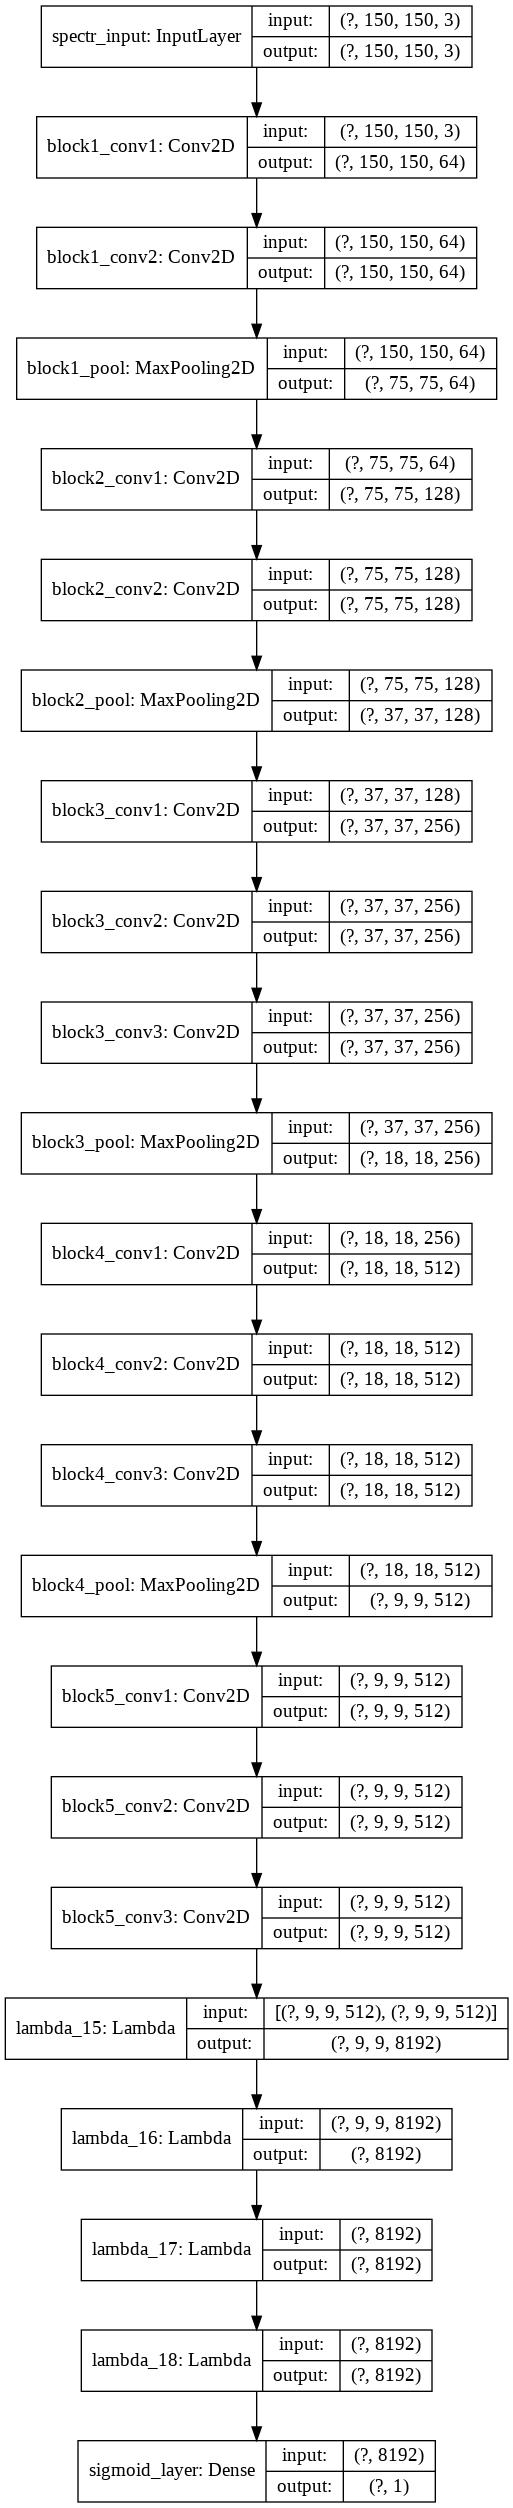

In [ ]:
plot_model(model, to_file='/content/drive/My Drive/final_year_project/model_plot-4-cnn.jpeg', show_shapes=True, show_layer_names=True)